Starting host segmentation analysis for file: /content/Airbnb_Open_Data.xlsx
Data loaded successfully. Shape: (102599, 26)

Data preprocessing complete. Total features for clustering: 11
Applying K-Means clustering with K=4...

--- Model Output: Cluster Centers (Scaled Values) ---
Cluster Center Profiles (Higher absolute value means more influential for that cluster):
   price  minimum_nights  host_listings_count  availability_365  \
0 -0.008           0.101                0.013             1.268   
1  0.010          -0.059               -0.159            -0.609   
2  0.013           0.686                7.375             0.756   
3 -0.004          -0.062               -0.153            -0.595   

   yield_efficiency_score  policy_strictness_index  instant_bookable_num  \
0                  -0.003                   -0.002                   0.0   
1                  -0.836                    0.001                   0.0   
2                   0.171                   -0.028               

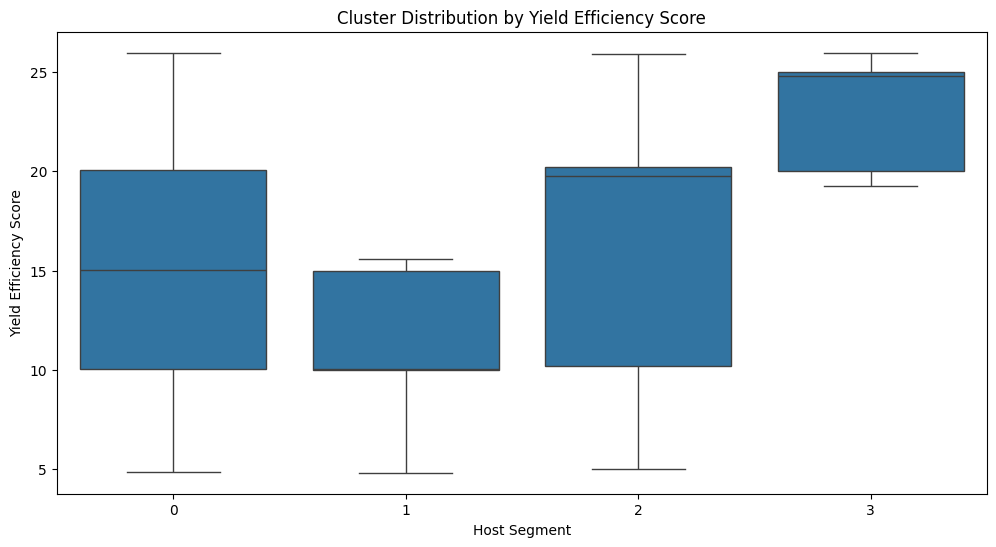

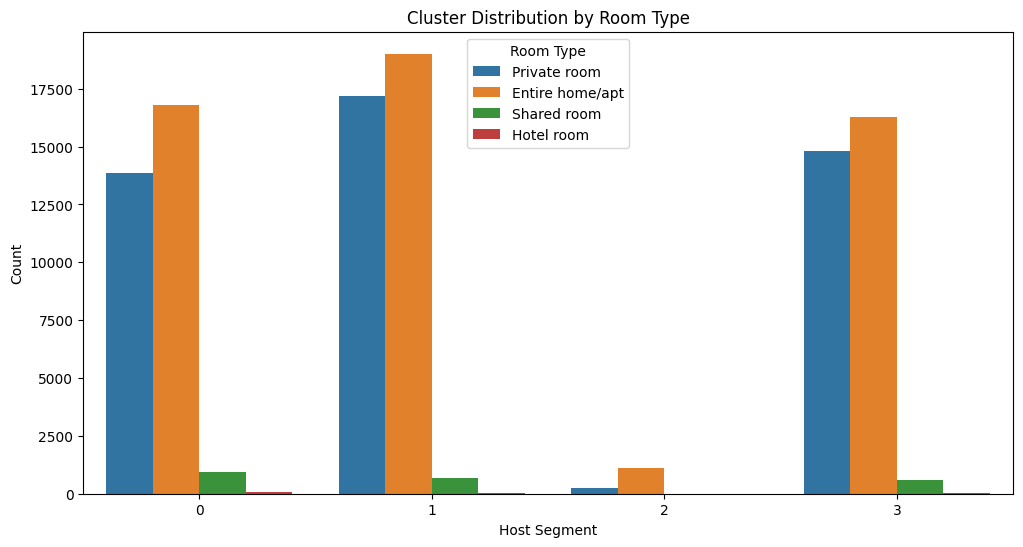


--- Analysis Complete ---
The resulting 'cluster' column in the dataset can be used to generate the Strategic Profiles (Section C of the Problem Statement).


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer # Import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# NOTE: Replace '1730285881-Airbnb_Open_Data.xlsx - in.csv' with the actual path if the file is moved.
FILE_PATH = '/content/Airbnb_Open_Data.xlsx'
N_CLUSTERS = 4 # Based on the 3-5 range specified in the problem statement

print(f"Starting host segmentation analysis for file: {FILE_PATH}")

try:
    # 1. Data Loading
    df = pd.read_excel(FILE_PATH )
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}. Please ensure the CSV is in the correct directory.")
except Exception as e:
    print(f"An error occurred during file loading: {e}")


# Rename columns for easier access (using observed column structure)
if 'df' in locals(): # Check if df was successfully created
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df = df.rename(columns={
        'host_id': 'host_id',
        'neighbourhood_group': 'region',
        'cancellation_policy': 'cancellation_policy',
        'room_type': 'room_type',
        'calculated_host_listings_count': 'host_listings_count',
        'review_rate_number': 'review_rate'
    })


    # 2. Data Cleaning and Preparation
    # Select and filter core columns needed for clustering
    core_features = [
        'price', 'service_fee', 'minimum_nights', 'number_of_reviews',
        'review_rate', 'host_listings_count', 'availability_365',
        'instant_bookable', 'cancellation_policy', 'room_type'
    ]
    df_clean = df[core_features].copy()

    # Convert price and service_fee to numeric, coercing errors to NaN
    for col in ['price', 'service_fee']:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Drop rows with critical missing values for analysis
    df_clean.dropna(subset=['price', 'service_fee', 'review_rate', 'cancellation_policy', 'room_type'], inplace=True)

    # Convert boolean/string 'instant_bookable' to numeric (1/0)
    df_clean['instant_bookable_num'] = df_clean['instant_bookable'].apply(lambda x: 1 if str(x).lower() == 'true' else 0)


    # 3. Feature Engineering (as defined in the Problem Statement)

    # A. Yield Efficiency Score (Higher is better: High Price, Low Service Fee, High Review Rate)
    # A simple inverse scaling might be needed for service fee percentage if it's high for low-value bookings.
    # Assumption: review_rate is 1-5, price and service_fee are raw values.
    # Score = (Price * Review_Rate) / Service_Fee
    # We add a small constant to Service_Fee to prevent division by zero or overly large values
    df_clean['yield_efficiency_score'] = (df_clean['price'] * df_clean['review_rate']) / (df_clean['service_fee'] + 0.01)

    # B. Policy Strictness Index (Categorical to Numerical)
    # Maps strictness to a numerical scale: flexible=1, moderate=2, strict=3
    policy_map = {'flexible': 1, 'moderate': 2, 'strict': 3}
    df_clean['policy_strictness_index'] = df_clean['cancellation_policy'].map(policy_map).fillna(1)


    # 4. Preparing Features for Clustering
    numerical_features = [
        'price', 'minimum_nights', 'host_listings_count',
        'availability_365', 'yield_efficiency_score',
        'policy_strictness_index', 'instant_bookable_num'
    ]

    categorical_features = ['room_type']

    # Create the preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='drop' # Drop other columns not used in the model
    )

    # Add an imputer to the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('imputer', SimpleImputer(strategy='mean'))]) # Impute missing values with the mean

    # Fit and transform the data
    X_processed = pipeline.fit_transform(df_clean)
    feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))


    print(f"\nData preprocessing complete. Total features for clustering: {X_processed.shape[1]}")


    # 5. Segmentation Model Development (K-Means Clustering)
    print(f"Applying K-Means clustering with K={N_CLUSTERS}...")
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10, verbose=0)
    df_clean['cluster'] = kmeans.fit_predict(X_processed)

    print("\n--- Model Output: Cluster Centers (Scaled Values) ---")
    # Create a DataFrame for cluster centers for interpretation
    cluster_centers = pd.DataFrame(
        kmeans.cluster_centers_,
        columns=feature_names
    ).round(3)

    print("Cluster Center Profiles (Higher absolute value means more influential for that cluster):")
    print(cluster_centers)

    # Optional: Add mean original values for easier business interpretation
    print("\n--- Cluster Mean Values (Original Scale) ---")
    cluster_profiles_mean = df_clean.groupby('cluster')[numerical_features].mean()
    print(cluster_profiles_mean)

    print("\n--- Cluster Room Type Distribution ---")
    cluster_profiles_room_type = df_clean.groupby('cluster')['room_type'].value_counts(normalize=True).unstack(fill_value=0)
    print(cluster_profiles_room_type)


    # 6. Visualization for Strategic Profile Generation
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='cluster', y='yield_efficiency_score', data=df_clean)
    plt.title('Cluster Distribution by Yield Efficiency Score')
    plt.xlabel('Host Segment')
    plt.ylabel('Yield Efficiency Score')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.countplot(x='cluster', hue='room_type', data=df_clean)
    plt.title('Cluster Distribution by Room Type')
    plt.xlabel('Host Segment')
    plt.ylabel('Count')
    plt.legend(title='Room Type')
    plt.show()

    print("\n--- Analysis Complete ---")
    print(f"The resulting 'cluster' column in the dataset can be used to generate the Strategic Profiles (Section C of the Problem Statement).")
else:
    print("\nAnalysis could not proceed due to errors during data loading.")